In [ ]:
import os, random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from google.colab import drive
drive.mount('/content/drive')

directory = Path("/content/drive/MyDrive/Colab Notebooks/Blood cells dataset")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Lecture Dataset 1

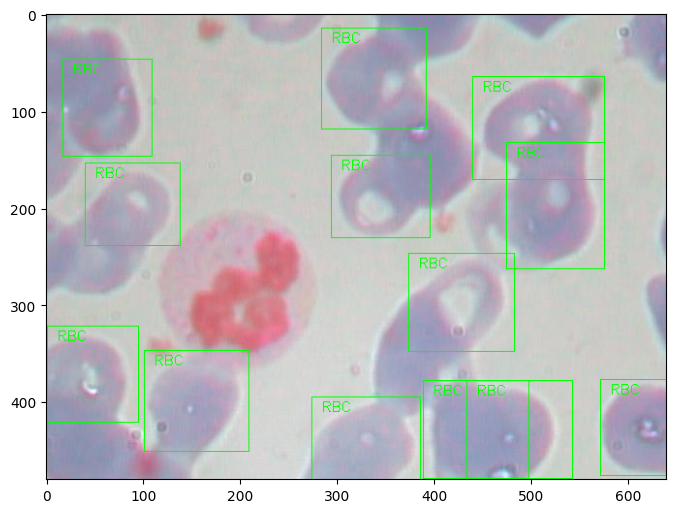

In [ ]:
# Note that the code below is from https://www.kaggle.com/code/paultimothymooney/identify-blood-cell-subtypes-from-images/notebook
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Blood cells dataset/dataset-master/JPEGImages/BloodImage_00022.jpg")
tree = ET.parse("/content/drive/MyDrive/Colab Notebooks/Blood cells dataset/dataset-master/Annotations/BloodImage_00022.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.show()

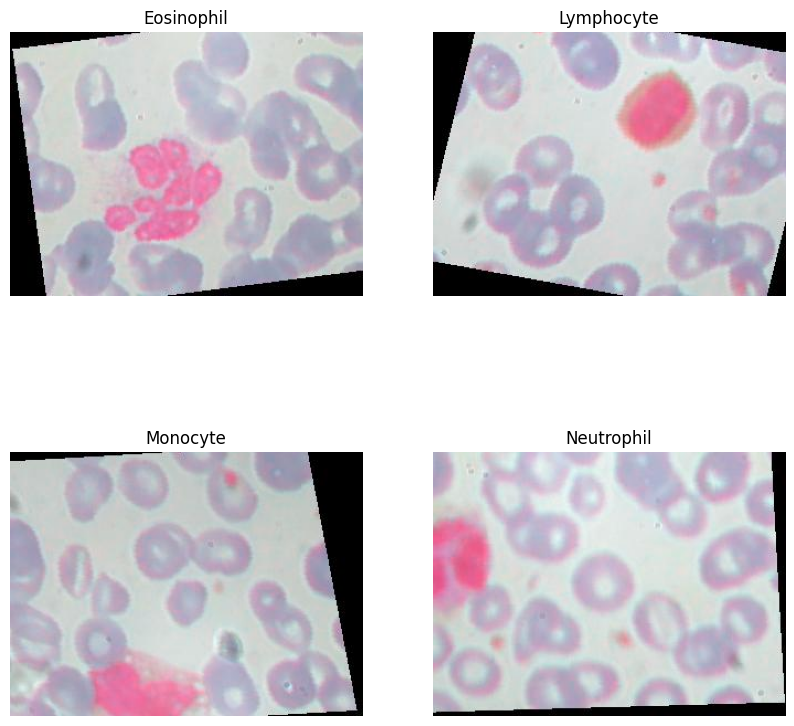

In [ ]:
# Note that the code below is from https://www.kaggle.com/code/paultimothymooney/identify-blood-cell-subtypes-from-images/notebook

# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return
image_name = '/content/drive/MyDrive/Colab Notebooks/Blood cells dataset/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off')
plotImage(image_name)
image_name = '/content/drive/MyDrive/Colab Notebooks/Blood cells dataset/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off')
plotImage(image_name)
image_name = '/content/drive/MyDrive/Colab Notebooks/Blood cells dataset/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off')
plotImage(image_name)
plt.subplot(224)
image_name = '/content/drive/MyDrive/Colab Notebooks/Blood cells dataset/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil')
plt.axis('off')
plotImage(image_name)

[  3  88  33  21 207]


/tmp/ipython-input-3033594992.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))


Text(0, 0.5, 'Counts')

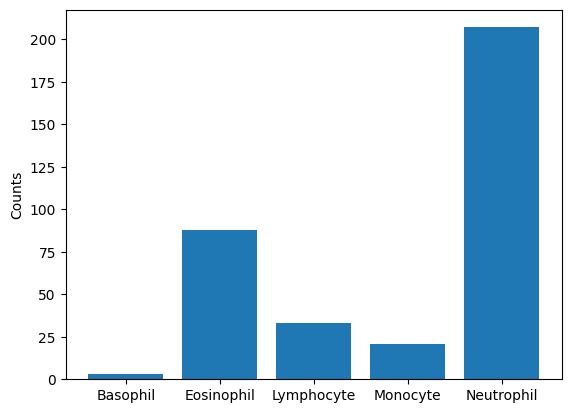

In [ ]:
# Note that the function below is from https://www.kaggle.com/code/paultimothymooney/identify-blood-cell-subtypes-from-images/notebook

reader = csv.reader(open('/content/drive/MyDrive/Colab Notebooks/Blood cells dataset/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

#Lecture Dataset 2 - augmented data

In [ ]:
import os
from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np

subtypes_id = {
    "NEUTROPHIL": 0,
    "EOSINOPHIL": 1,
    "MONOCYTE":   2,
    "LYMPHOCYTE": 3,
}
# nucleus_id : 1 if neutrophil/eosinophil, 0 else
nucleus_id = {"NEUTROPHIL", "EOSINOPHIL"}

def get_data(root, img_size=(128, 128)):

    root = Path(root)
    X, y, z = [], [], []
    exts = {".jpg", ".jpeg"}

    for cls_name in sorted(subtypes_id.keys()):
        class_dir = root / cls_name
        if not class_dir.is_dir():
            continue
        files = [p for p in class_dir.iterdir() if p.suffix.lower() in exts]
        for p in tqdm(files, desc=f"Load {cls_name}"):
            img = cv2.imread(str(p))
            if img is None:
                continue

            # BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
            # Normalisation
            img = img.astype(np.float32) / 255.0

            X.append(img)
            y.append(subtypes_id[cls_name])
            z.append(1 if cls_name in nucleus_id else 0)

    X = np.stack(X) if X else np.empty((0, img_size[1], img_size[0], 3), dtype=np.float32)
    y = np.asarray(y, dtype=np.int64)
    z = np.asarray(z, dtype=np.int64)
    return X, y, z

X_train, y_train, z_train = get_data('/content/drive/MyDrive/Colab Notebooks/Blood cells dataset/dataset2-master/images/TRAIN', img_size=(128,128))
X_test,  y_test,  z_test  = get_data('/content/drive/MyDrive/Colab Notebooks/Blood cells dataset/dataset2-master/images/TEST',  img_size=(128,128))


from tensorflow.keras.utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes=4)
y_testHot  = to_categorical(y_test,  num_classes=4)
z_trainHot = to_categorical(z_train, num_classes=2)
z_testHot  = to_categorical(z_test,  num_classes=2)


dict_subtypes = {v: k for k, v in subtypes_id.items()}
dict_nucleus  = {0: "mononucleus (LYM/MON)", 1: "granulocyte (NEU/EOS)"}
print(dict_subtypes)
print(dict_nucleus)


Load NEUTROPHIL: 100%|██████████| 624/624 [00:04<00:00, 148.13it/s]

{0: 'NEUTROPHIL', 1: 'EOSINOPHIL', 2: 'MONOCYTE', 3: 'LYMPHOCYTE'}
{0: 'mononucleus (LYM/MON)', 1: 'granulocyte (NEU/EOS)'}


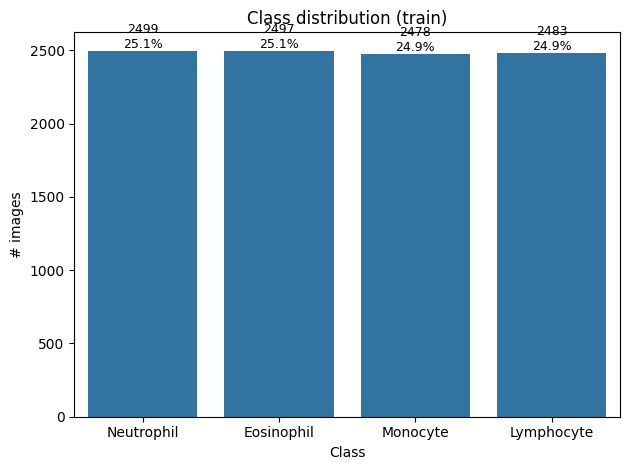

{0: 'Neutrophil', 1: 'Eosinophil', 2: 'Monocyte', 3: 'Lymphocyte'}


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# y_train = np.array([...])
name_map = {0:'Neutrophil', 1:'Eosinophil', 2:'Monocyte', 3:'Lymphocyte'}

df = pd.DataFrame({'label_id': y_train})
df['label'] = df['label_id'].map(name_map)

order = ['Neutrophil','Eosinophil','Monocyte','Lymphocyte']
ax = sns.countplot(x='label', data=df, order=order)
ax.set_title("Class distribution (train)")
ax.set_xlabel("Class"); ax.set_ylabel("# images")


total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    pct = 100 * count / total if total else 0
    ax.annotate(f'{count}\n{pct:.1f}%',
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout(); plt.show()

print(name_map)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
print("class_weight:", class_weight)


class_weight: {0: 0.9960984393757503, 1: 0.9968962755306368, 2: 1.0045399515738498, 3: 1.002517116391462}


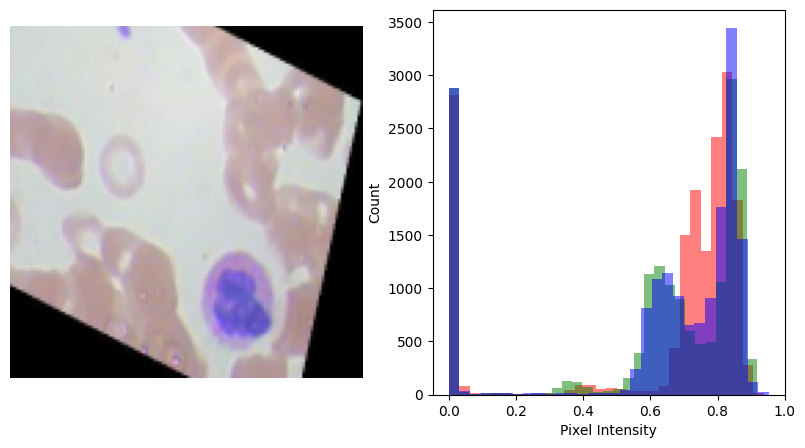

In [ ]:
# Note that the function below is from https://www.kaggle.com/code/paultimothymooney/identify-blood-cell-subtypes-from-images/notebook

def plotHistogram(a):
    # histogram of RGB Pixel Intensities

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

plotHistogram(X_train[1])

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# build a validation set from the train set
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_trainHot,
    test_size=0.2,
    stratify=y_trainHot,
    random_state=42
)

print("X_tr:", X_tr.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


X_tr: (7965, 128, 128, 3) X_val: (1992, 128, 128, 3) X_test: (2487, 128, 128, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn(input_shape, num_classes=4, dropout=0.3):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Bloc 1
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)  # 64x64

    # Bloc 2
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)  # 32x32

    # Bloc 3
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)  # 16x16

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

num_classes = y_trainHot.shape[1]
model = build_cnn(X_tr.shape[1:], num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,436 (368.89 KB)

 Trainable params: 93,988 (367.14 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
]


In [ ]:
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4182 - loss: 1.2810
Epoch 1: val_accuracy improved from -inf to 0.32530, saving model to best_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.4186 - loss: 1.2802 - val_accuracy: 0.3253 - val_loss: 4.9692 - learning_rate: 0.0010
Epoch 2/40
247/249 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7110 - loss: 0.7598
Epoch 2: val_accuracy did not improve from 0.32530
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7114 - loss: 0.7588 - val_accuracy: 0.2967 - val_loss: 4.7318 - learning_rate: 0.0010
Epoch 3/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8144 - loss: 0.5176
Epoch 3: val_accuracy did not improve from 0.32530
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8145 - loss: 0.5174 - val_accuracy: 0.2736 - val_loss: 4.1292 - learning_rate: 0.0010
Epoch 4/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8494 - loss: 0.4156
Epoch 4: val_accuracy improved from 0.3253

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_testHot, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8646 - loss: 0.4272
Test accuracy: 0.8701


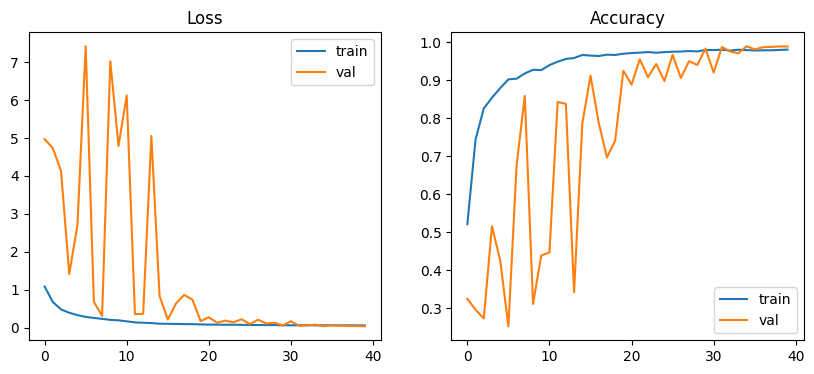

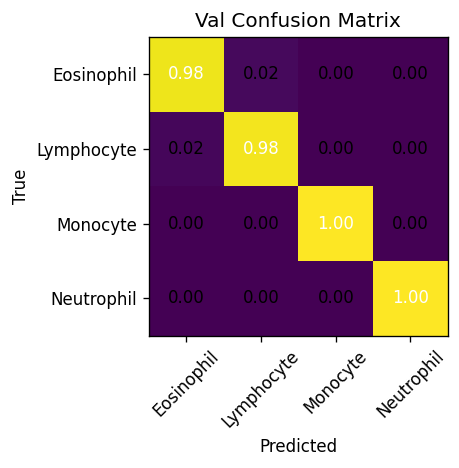

              precision    recall  f1-score   support

  Eosinophil      0.982     0.976     0.979       500
  Lymphocyte      0.976     0.982     0.979       499
    Monocyte      1.000     1.000     1.000       496
  Neutrophil      1.000     1.000     1.000       497

    accuracy                          0.989      1992
   macro avg      0.989     0.989     0.989      1992
weighted avg      0.989     0.989     0.989      1992



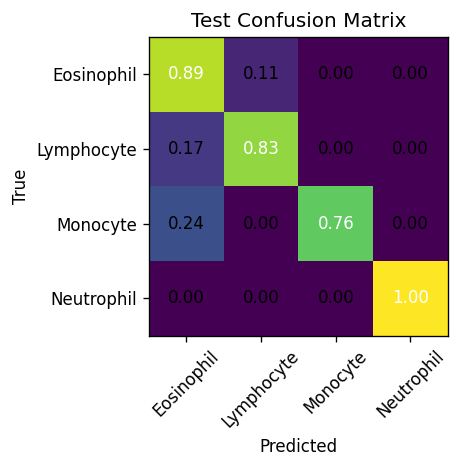

              precision    recall  f1-score   support

  Eosinophil      0.686     0.891     0.775       624
  Lymphocyte      0.884     0.835     0.859       623
    Monocyte      1.000     0.756     0.861       620
  Neutrophil      1.000     0.998     0.999       620

    accuracy                          0.870      2487
   macro avg      0.892     0.870     0.874      2487
weighted avg      0.892     0.870     0.873      2487



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Plot curves
h = history.history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(h['loss']); plt.plot(h['val_loss']); plt.title('Loss'); plt.legend(['train','val'])
plt.subplot(1,2,2); plt.plot(h['accuracy']); plt.plot(h['val_accuracy']); plt.title('Accuracy'); plt.legend(['train','val'])
plt.show()

# Confusion matrix
import numpy as np
def plot_cm(y_true_onehot, y_pred_prob, class_names, normalize=True, title="Confusion Matrix"):
    y_true = np.argmax(y_true_onehot, axis=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True).clip(min=1)
    plt.figure(figsize=(5,4), dpi=120)
    plt.imshow(cm); plt.title(title)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, f"{cm[i,j]:.2f}" if normalize else f"{cm[i,j]}", ha='center', va='center', color='white' if cm[i,j]>(cm.max()/2) else 'black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

class_names = ["Eosinophil","Lymphocyte","Monocyte","Neutrophil"]

# Validation
val_prob = model.predict(X_val, verbose=0)
plot_cm(y_val, val_prob, class_names, normalize=True, title="Val Confusion Matrix")

# Test
test_prob = model.predict(X_test, verbose=0)
plot_cm(y_testHot, test_prob, class_names, normalize=True, title="Test Confusion Matrix")
